## Project 1
### Group 1 - Adam G, Maria G, Diego C


### Problem Set
Centrality measures can be used to predict (positive or negative) outcomes for a node.
Your task in this week’s assignment is to identify an interesting set of network data that is available on the web
(either through web scraping or web APIs) that could be used for analyzing and comparing centrality measures across nodes.

As an additional constraint, there should be at least one categorical variable available for each node
(such as “Male” or “Female”; “Republican”, “Democrat,” or “Undecided”, etc.)

In addition to identifying your data source, you should create a high level plan that describes how you would load the data for analysis,
and describe a hypothetical outcome that could be predicted from comparing degree centrality across categorical groups.
For this week’s assignment, you are not required to actually load or analyze the data.  Please see also Project 1 below.
You may work in a small group on the assignment.   You should post your document to GitHub by end of day on Sunday.

## Introduction

In our project, we take a look at a network of stocks and institutional holders.  Instiutional holders include any mutual or pension funds, insurance company, investment firms, private foundation, endowment, or other large entities that manage funds on behalf others.  In our social network analysis, our nodes are either a stock or institutional holder and the edges are interactions between the institutional holder and stock.

To conduct our analysis, we use a Dow Jones Industrial Average dataset to extract the ticker information and use the yfinance package to pull the institutional holder dataframes.

The Dow Industrial Average consist of the 30 companies and the index weight of each.  The yfinanace package is an open source tool that uses Yahoo's publicly available APIs.  It offers a threaded Pythonic way to download data from Yahoo finance.

The analysis will begin with extraction, transformation, and loading of the desired data. Next, we create and perform basic exploration of the social network. Finally, we will perform an analysis by categorical groups.

[Link to recording](https://www.youtube.com/watch?v=6R9peqGYKMI)

### Required Packages

In [1]:
import yfinance as yf
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from networkx import algorithms

### ETL

We begin by scrapping the Dow Jones data from a webpage. Below is a view of the table.

In [2]:
# scraping company tickers and info
tickers_df = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
tickers_df.head(5)

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.02%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.60%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,4.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.25%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.96%


Capturing the Dow Jones tickers into a list. 

In [3]:
ticker_list = list(tickers_df['Symbol'])
print(ticker_list)

['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT']


Here, we will create ticker classes using the yfinance package for each symbol.  This allows us to store the institutional holder dataframe for each ticker and concatenate into one dataframe.

We add a column to this data frame that contains the ticker symbol of each ticker, respectively.  We use this method to create a mapping back to ticker and the rest of the institutional holder. 

In [4]:
# create dictionary with the stored symbols as keys
ticker_dict = dict.fromkeys(ticker_list)

# loop through keys to create ticker class and store institutional holders df
for comp in ticker_dict:
    ticker = yf.Ticker(comp)
    inst_hol = ticker.institutional_holders
    inst_hol['comp'] = comp
    ticker_dict[comp] = inst_hol
    
# concatenate 30 dfs into 1    
institutional_holders = pd.concat(ticker_dict.values(), ignore_index=True)

Taking a look at the entire institutional holder dataframe. 

In [5]:
institutional_holders

,Holder,Shares,Date Reported,% Out,Value,comp
0,"Vanguard Group, Inc. (The)",50240763,2021-12-30,0.0880,8924266731,MMM
1,Blackrock Inc.,41810186,2021-12-30,0.0732,7426743339,MMM
2,State Street Corporation,30979936,2021-12-30,0.0542,5502966031,MMM
3,"Geode Capital Management, LLC",10780080,2021-12-30,0.0189,1914865610,MMM
4,"Charles Schwab Investment Management, Inc.",10557291,2021-12-30,0.0185,1875291600,MMM
...,...,...,...,...,...,...
295,Northern Trust Corporation,16607064,2021-12-30,0.0060,2402876090,WMT
296,Morgan Stanley,15580922,2021-12-30,0.0056,2254403604,WMT
297,Norges Bank Investment Management,15012238,2020-12-30,0.0054,2164014107,WMT
298,State Farm Mutual Automobile Insurance Co,13083050,2021-12-30,0.0047,1892986504,WMT


### Social Network

From the insitutional holder dataframe, we are able to construct a social network.

In [6]:
# creating network from df
# in order to be able to utilize the edges we need to set edge_att= True
g = nx.from_pandas_edgelist(institutional_holders, 'Holder', 'comp', edge_attr=True)
edgelist = nx.to_edgelist(g)

To easily understand the nodes, we change the colors of the nodes to understand who are the companies (Blue) and who are the institutional holders (orange).  Additionally, we label them as such.

In [7]:
# assigning color and type to node
colors = []
for node in g:
    if node in institutional_holders['comp'].values:
        colors.append("blue")
        g.nodes[node]['type'] = 'stock'
    else:
        colors.append("orange")
        g.nodes[node]['type'] = 'holder'

### Exploration

Below we see basic information of the social network.

In [8]:
# storing basic network info in dictionary 
network_info = {}

network_info['connected'] = nx.is_connected(g)
network_info['diameter'] = nx.diameter(g)
network_info['num_of_nodes'] = g.number_of_nodes()
network_info['num_of_edges'] = g.number_of_edges()
network_info['avg_shortest_path'] = algorithms.average_shortest_path_length(g)

# output as table
pd.DataFrame.from_dict(network_info, orient='index', columns=['Values'])

,Values
connected,True
diameter,4
num_of_nodes,67
num_of_edges,300
avg_shortest_path,2.521936


#### Graph Network

Next, we take our first look at the network.

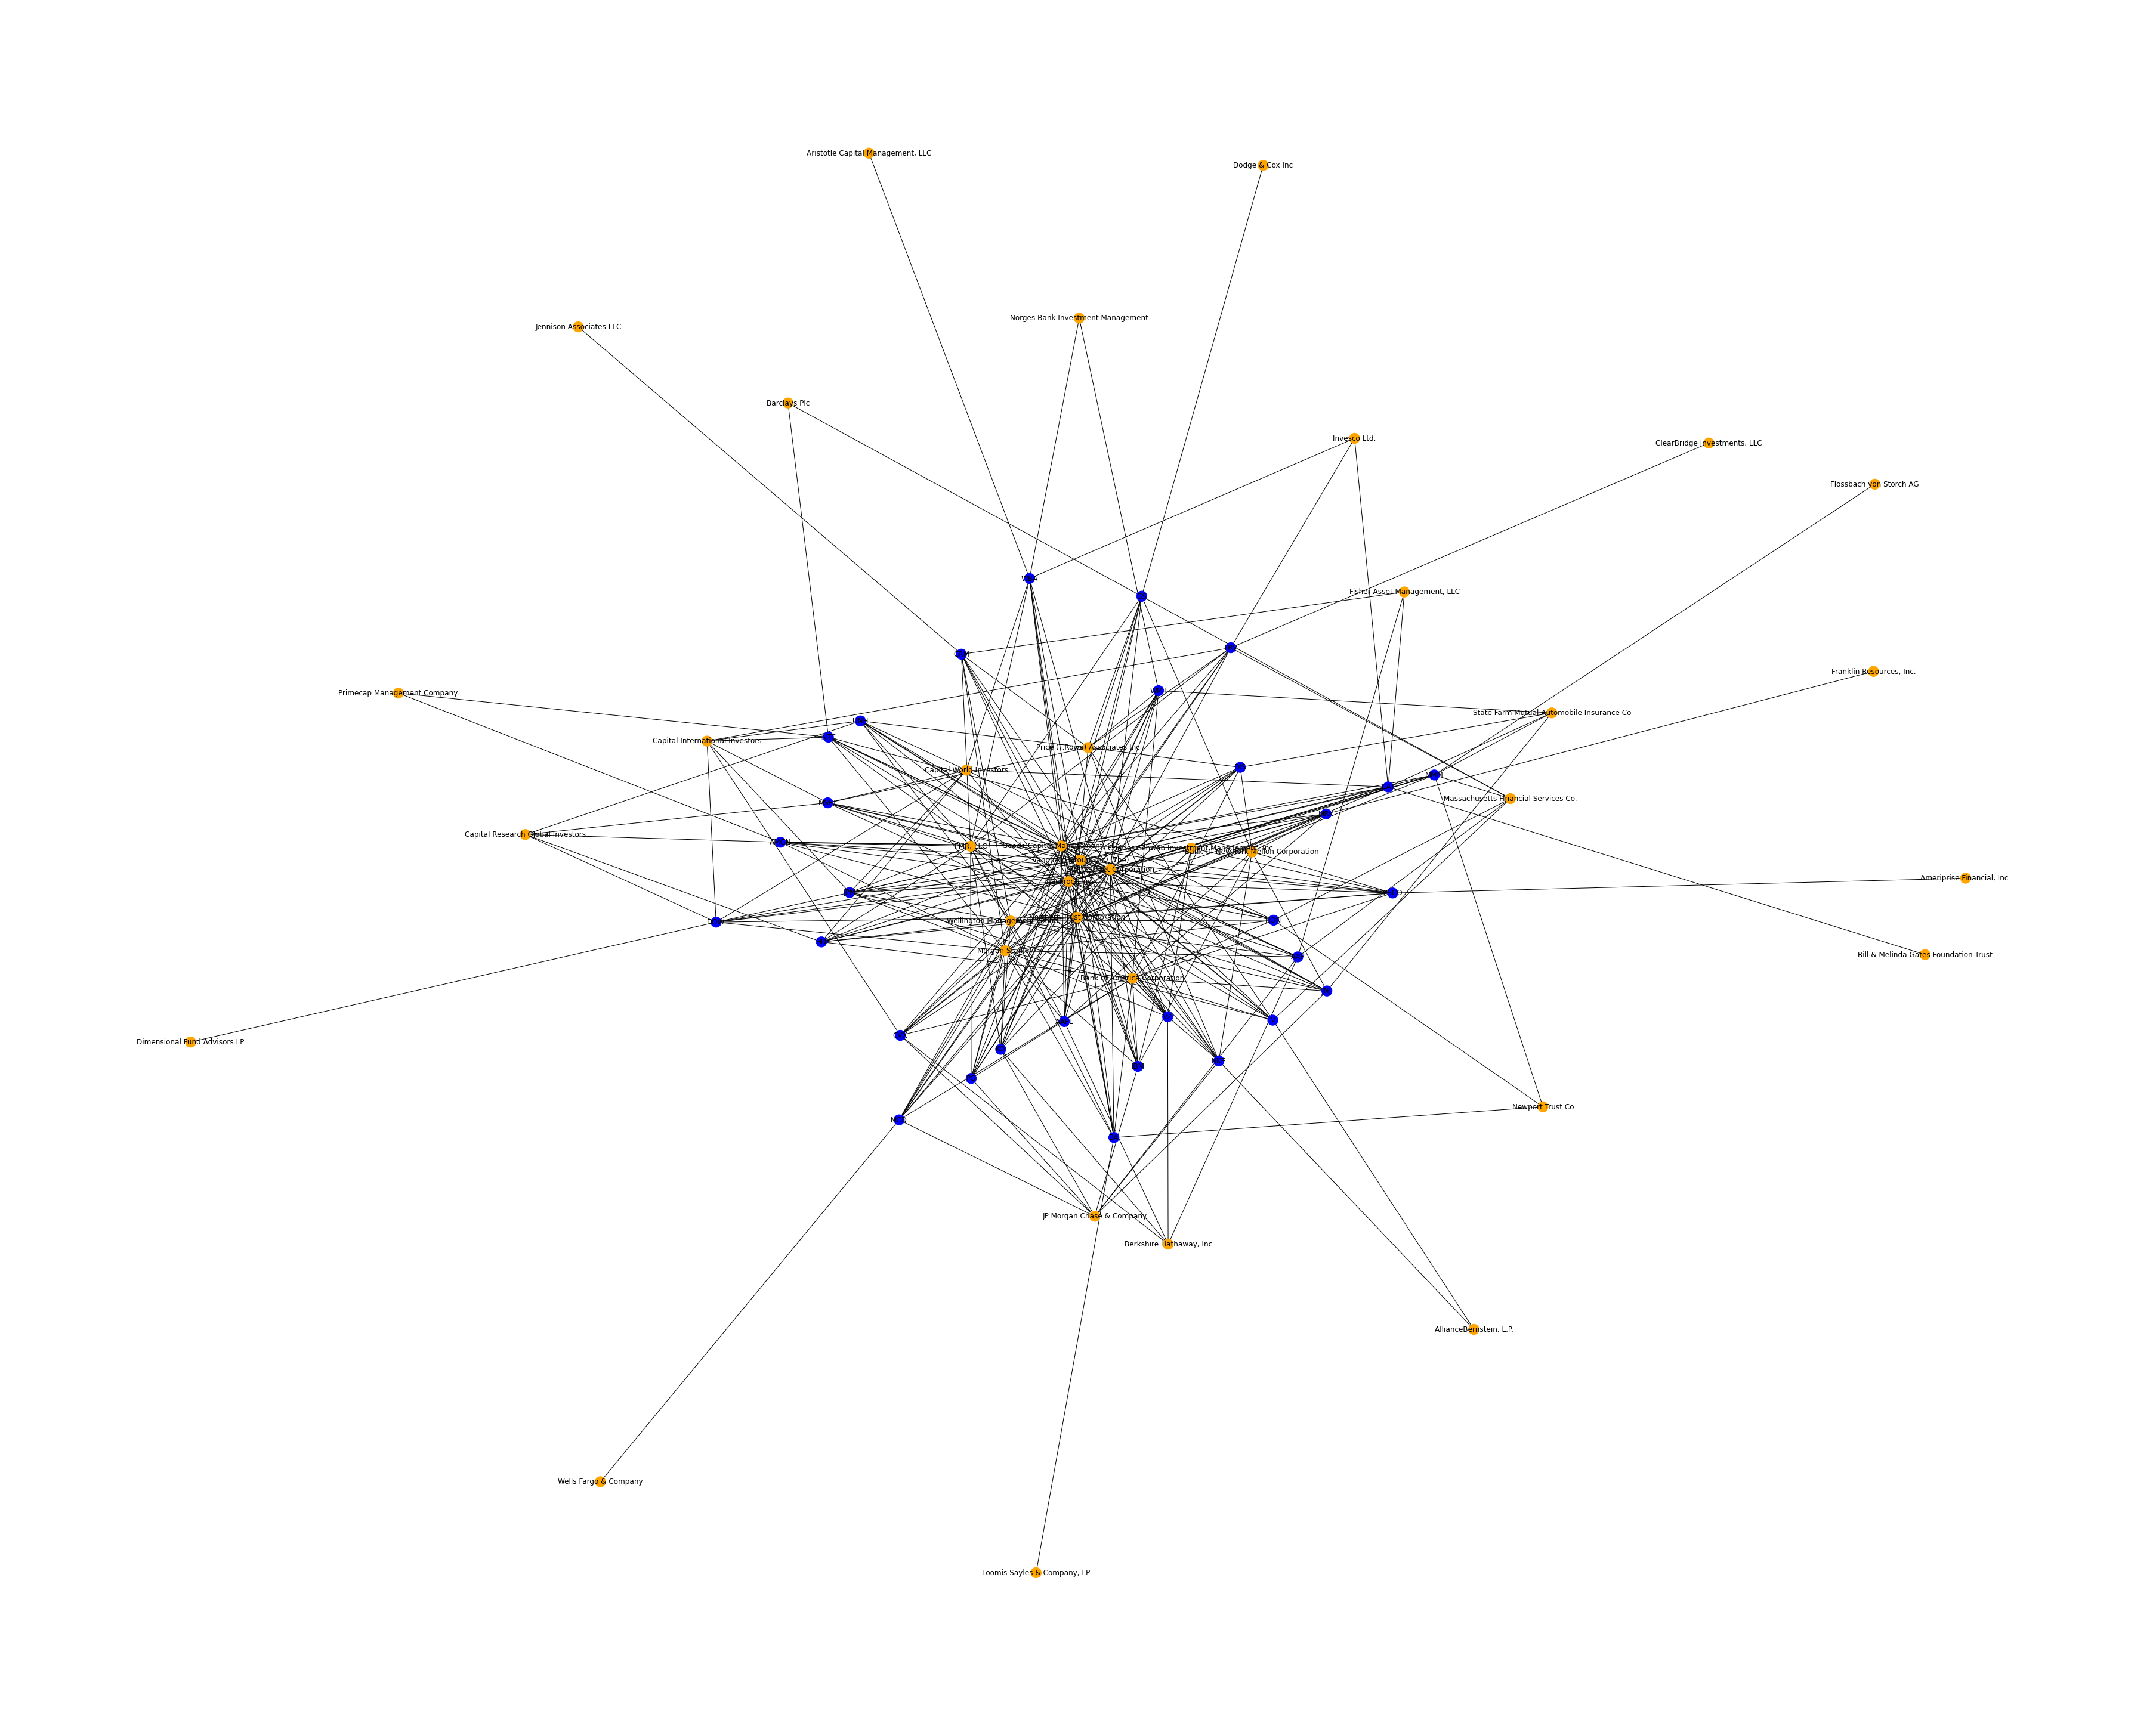

In [9]:
# view basic graph
plt.figure(figsize=(50,40))
nx.draw(g, with_labels=True,
        node_color=colors)

### Analysis 
Once we have loaded the dataframe of institutional holders of 30 companies, we will create a strategy to analyze Degree centrality between institutional holders and stocks.

### Degree
We begin by capturing the degree of each node in a dataframe along with the name of the node and type.  This shows us the number of connections a node has. 

In [10]:
# creating df with node names and type
type = dict(g.nodes) 
temp_dict = {}
for x in type:
    temp_dict[x] = type[x]['type']

type_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Type'])

# creating df with node names and degree
deg = dict(g.degree())
deg_df = pd.DataFrame.from_dict(deg, orient='index', columns=['Degree'])

# joining df
df = type_df.join(deg_df)

# describing degree values
df['Degree'].describe()

count    67.000000
mean      8.955224
std       6.961872
min       1.000000
25%       3.000000
50%      10.000000
75%      10.000000
max      30.000000
Name: Degree, dtype: float64

Once the degree is captured in our dataframe we can visualize the distribution. 

The below graph the degree distribution of the institutional holders and stocks.  The distribution of institutional holders is skewed right with a mode at 30.  Whereas the stock distribution is static at 10.  This characteristic of the dataset, showing the top 10 institutional holders by stock.

In [22]:
# plot histogram
fig = px.histogram(df, x = 'Degree', color='Type', nbins=20, title='Degree Values by Type')
fig.show()

### Second Look at Network
Now that we explored the node's degree, we include this in our social network graph.  

Node Size - 
The degree is the number of relationships of the particular node. We used this to manipulate the size of the node.

Edge Weight - 
The edges represent the amount of money contributed to each company; therefore, we need to normalize the edges' weights.

This view of the network clearly illustrates the cluster of institutional holders at the center of the network.  Moreover, the edge with the greatest weights (money invested) are all connected to AAPL and MSFT.

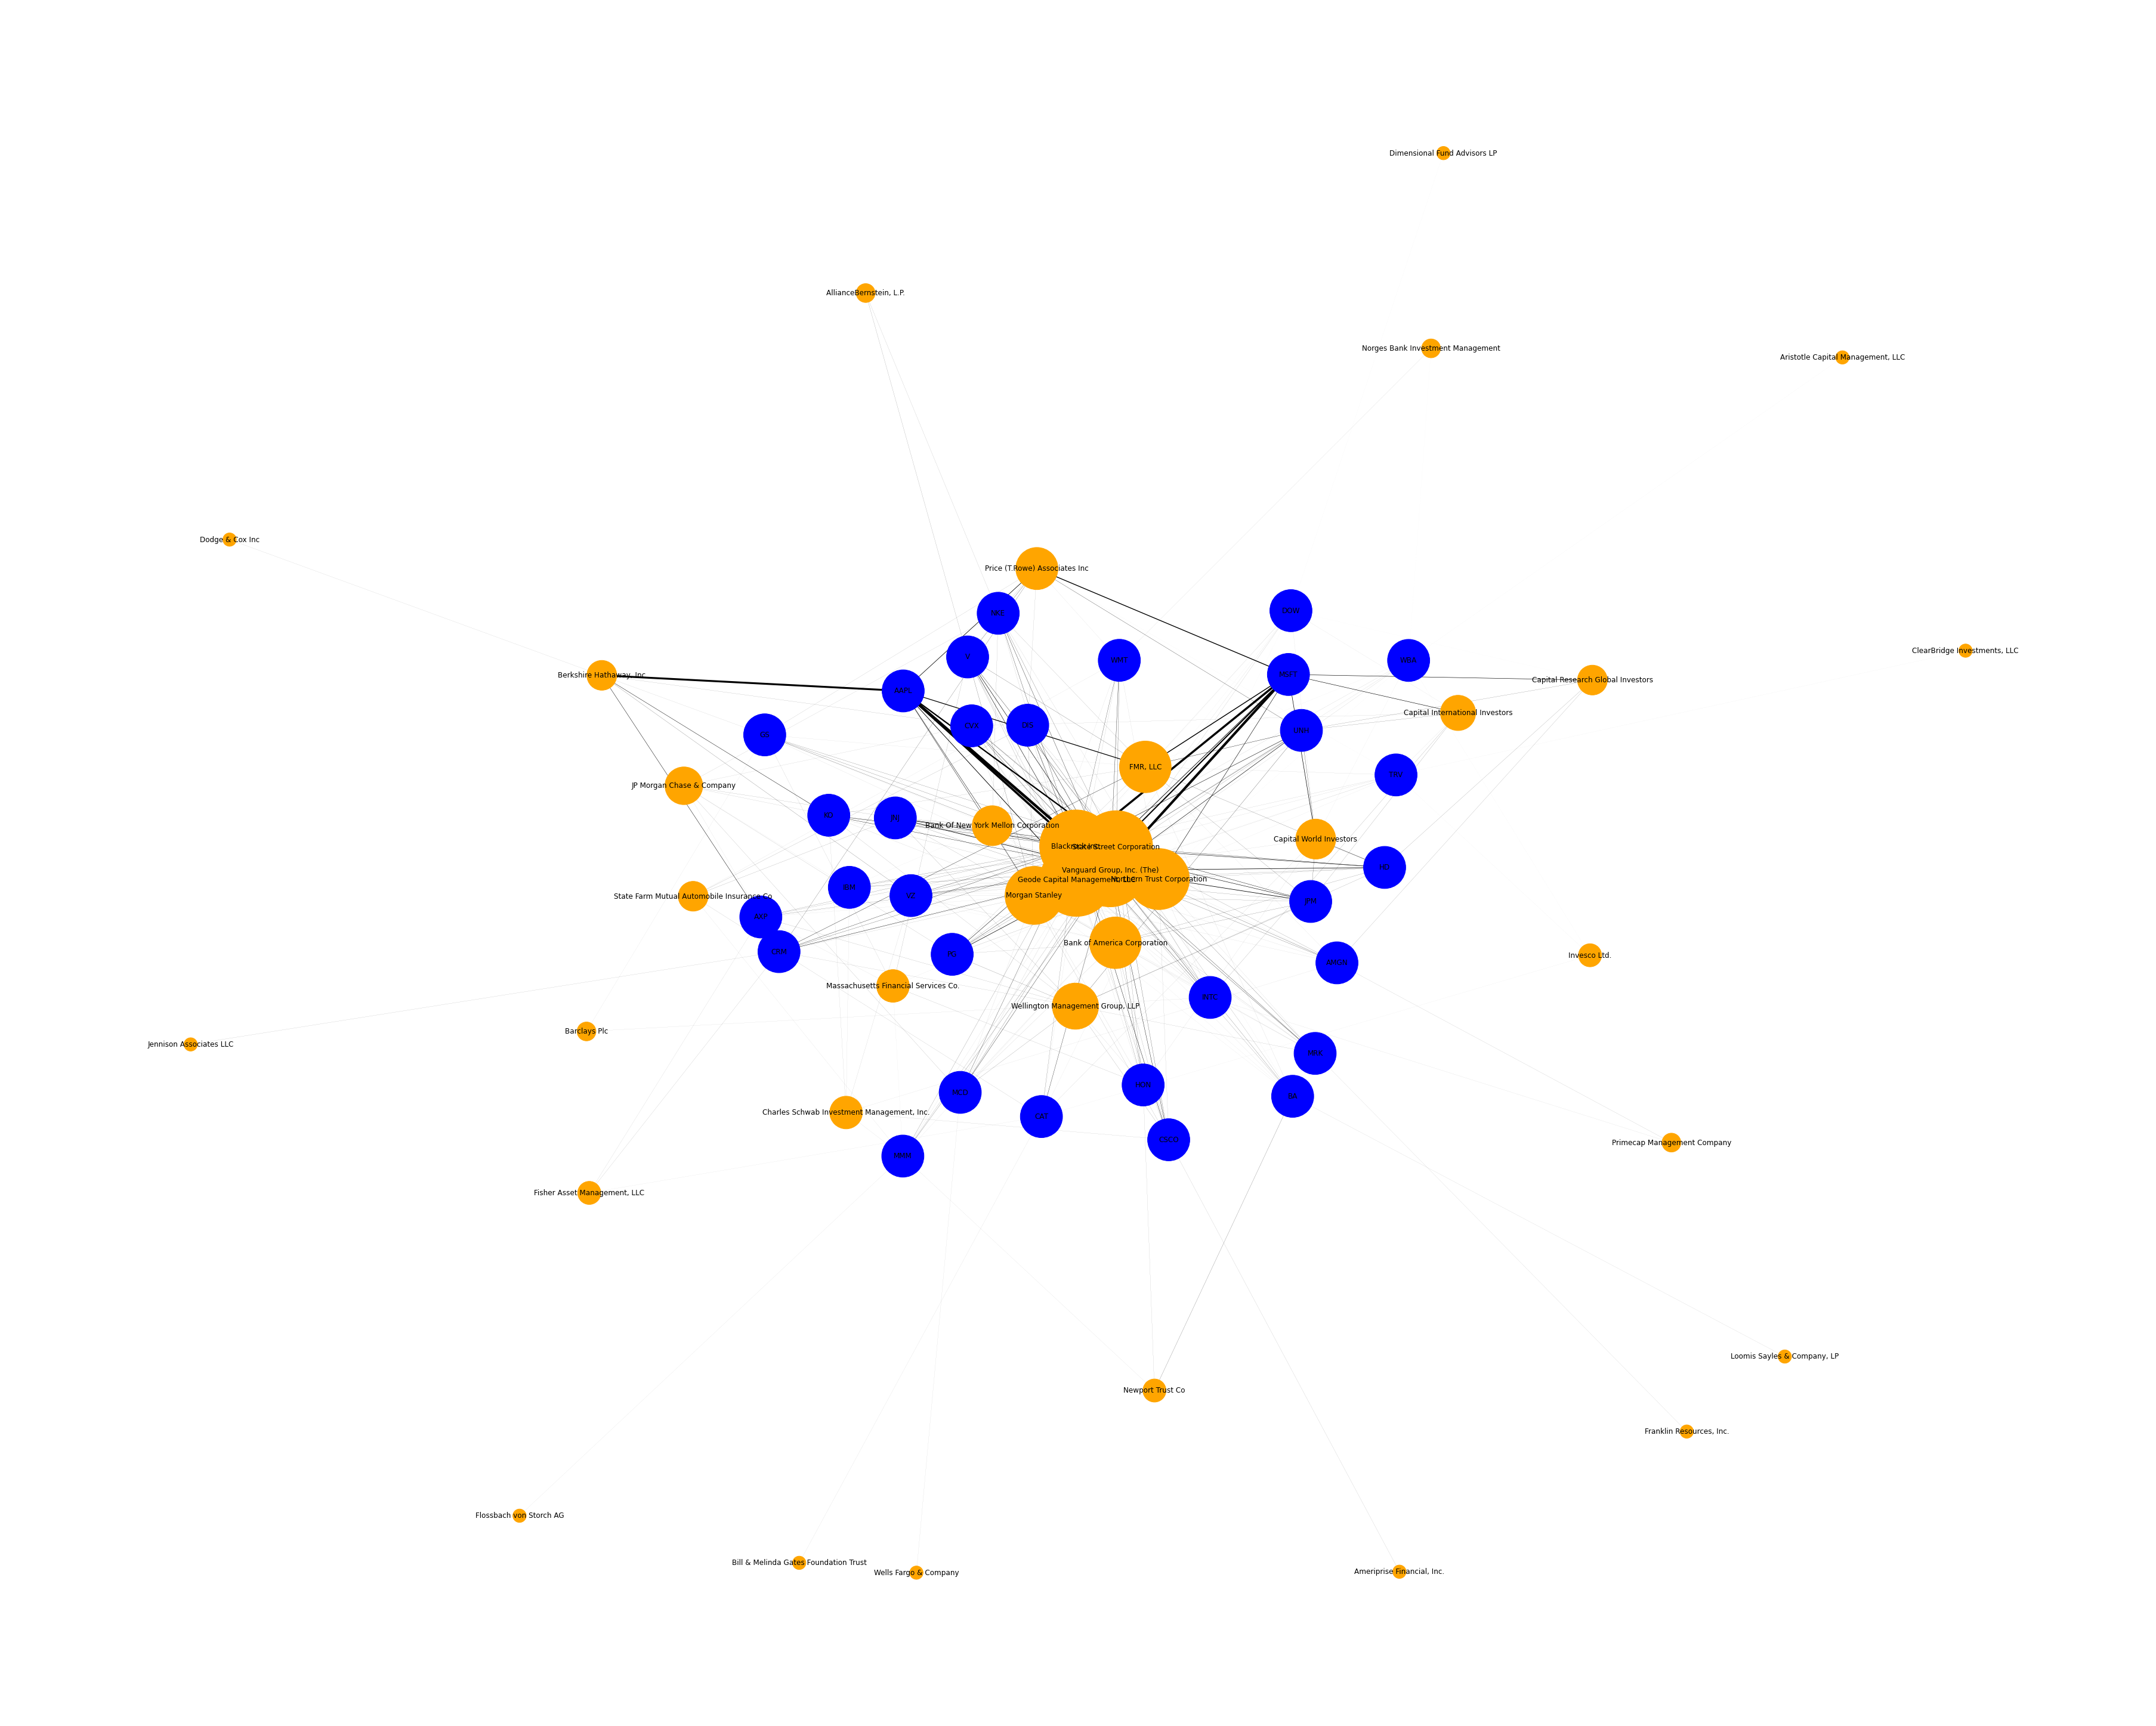

In [18]:
# view network graph that degree and value of node
plt.figure(figsize=(50,40))
nx.draw(g, with_labels=True,
        node_color=colors,
        node_size = [v * 500 for v in dict(g.degree()).values()],
                     width= [v[2]['Value'] /50_000_000_000 for v in edgelist])

### Eigenvector Values

Eigenvector Centrality is a recursive version of Degree Centrality. Recompute the scores of each node as a weighted sum of centralities of all nodes in a nodes neighborhood. 

In [13]:
# creating df for eigen values
eigen = dict(nx.eigenvector_centrality(g))
eigen_df = pd.DataFrame.from_dict(eigen, orient='index', columns=['Eigen'])

# joining to df
df = df.join(eigen_df)

# describing Eigen values
df['Eigen'].describe()

count    67.000000
mean      0.099869
std       0.070898
min       0.008117
25%       0.026704
50%       0.117801
75%       0.135828
max       0.282799
Name: Eigen, dtype: float64

Again, we view the values by type of node.  

In [21]:
# plot histogram
fig = px.histogram(df, x='Eigen', color='Type', nbins = 20, title = 'Eigen Values by Type')
fig.show()

Now taking a look at the entire dataframe. 

In [15]:
# looking at the df 
df.sort_values('Eigen', ascending=False).head(10)

,Type,Degree,Eigen
"Vanguard Group, Inc. (The)",holder,30,0.282799
"Geode Capital Management, LLC",holder,30,0.282799
Blackrock Inc.,holder,30,0.282799
State Street Corporation,holder,30,0.282799
Northern Trust Corporation,holder,21,0.201391
Morgan Stanley,holder,19,0.184694
Bank of America Corporation,holder,15,0.148470
PG,stock,10,0.146425
"FMR, LLC",holder,15,0.141000
DIS,stock,10,0.138390


### T-Test

T-test is used to determine the signficant difference of means in two groups, holder and stock nodes.  We will use the eigenvector and degree values across the two groups in our population.

In [16]:
# separate df by holder and stock
holder = df[df['Type']=='holder']
stock = df[df['Type']=='stock']

# perform T-test on Eigen values of each holder and stock
stats.ttest_ind(stock['Eigen'], holder['Eigen'])

Ttest_indResult(statistic=3.2098576468896964, pvalue=0.002064366041769534)

In [17]:
# perform T-test on Eigen values of each holder and stock
stats.ttest_ind(stock['Degree'], holder['Degree'])

Ttest_indResult(statistic=1.1080061355048887, pvalue=0.2719423709081101)

## Conclusion

By looking at the the results of the T-test using the degree and eigenvector values, we see that there is a significant difference in the means across the types of nodes, institutional holder and stock.  

In our case, institutional holders have a higher importance across the population in the social network than stock.  

Vanguard Group, Inc, Blackrock Inc., State Street Corporation, Geode Capital Management, LLC are the most connected with the highest degree and eigenvector values.

Moreover, we could use the social network graph to design a rec sys to predict  instiutional holders investments in the same or different companies.